<a href="https://colab.research.google.com/github/Seanwu003/titanic-analysis/blob/main/Task_04_%E9%90%B5%E9%81%94%E5%B0%BC%E8%99%9F%E5%AD%98%E6%B4%BB%E9%A0%90%E6%B8%AC%E5%B0%88%E9%A1%8C%E5%AF%A6%E4%BD%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# loading package
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(font_scale=1.56)
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold, learning_curve, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import RFECV
df = pd.read_csv('https://raw.githubusercontent.com/dsindy/kaggle-titanic/master/data/train.csv')
df_train = df.copy()
#df_train.head()
#df_train.info()
df_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [ ]:
#查看缺失值、填補 以及將要用欄位轉碼
missing_values = df_train.isnull().sum()
print(missing_values)

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


1. 請問資料中有哪些「欄位」你覺得是多餘的，在分析過程中應該被排除的呢？為什麼？

  **passengerId, Name, ticket。**

  **因為沒有任何數值規則以及含義,所以不能拿來預測依變數Y。**


In [ ]:
#2. 針對「有缺失值」的欄位，嘗試不同的處理策略（例如：常數、中位數、平均數填補）比較結果。
#有缺失值根據 Task_03 可以得知有age, cabin, embarked	Port of Embarkation

#針對cabin只能用填常數的方式補 先填入Unknown, 後續再編碼
#df_train['Cabin'] = df_train['Cabin'].fillna('Unknown')
#df_train['Cabin'] = df_train['Cabin'].map(lambda x: x[0])
#cabin_mapping = {label: idx for idx, label in enumerate(df_train['Cabin'].unique())}       #還要細查#
#df_train['Cabin'] = df_train['Cabin'].map(cabin_mapping)
#針對embarked	Port of Embarkation 先填入Unknown, 後續再編碼
#df_train['Embarked'] = df_train['Embarked'].map({'C': 0, 'Q': 1, 'S': 2, 'Unknown': 3})
#性別要轉碼   female: 0, male: 1
#df_train['Sex'] = df_train['Sex'].map({'female': 0, 'male': 1})

# 填補缺失值所需的欄位
df_train['Embarked'] = df_train['Embarked'].fillna(df_train['Embarked'].mode()[0])  # 使用眾數填補 Embarked 欄位
df_train['Sex'] = df_train['Sex'].map({'female': 0, 'male': 1})  # 性別轉碼
df_train['Cabin'] = df_train['Cabin'].fillna('Unknown').map(lambda x: x[0])  # Cabin 欄位填補為 'Unknown'，並取首字母

# 將 'Embarked' 和 'Cabin' 轉換為數值型資料
df_train['Embarked'] = df_train['Embarked'].map({'C': 0, 'Q': 1, 'S': 2, 'Unknown': 3})  # 編碼 'Embarked'

cabin_mapping = {label: idx for idx, label in enumerate(df_train['Cabin'].unique())}  # 編碼 'Cabin'
df_train['Cabin'] = df_train['Cabin'].map(cabin_mapping)

In [ ]:
####由於age缺失的樣本較多我們只針對age測驗####

# 目標變數和特徵變數
X = df_train[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Cabin']]
y = df_train['Survived']

In [ ]:
# 定義函式來填補不同策略，並計算準確率
def fill_and_train(strategy):
    # 複製資料
    df_temp = df_train.copy()

    # 根據策略填補缺失值
    if strategy == 'mean':
        df_temp['Age'] = df_temp['Age'].fillna(df_temp['Age'].mean())
    elif strategy == 'median':
        df_temp['Age'] = df_temp['Age'].fillna(df_temp['Age'].median())
    elif strategy == 'constant':
        df_temp['Age'] = df_temp['Age'].fillna(-1)  # 填補為 -1 或任何常數

    # 特徵欄位與目標變數
    X_temp = df_temp[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Cabin']]

    # 分割訓練與測試資料集
    X_train, X_test, y_train, y_test = train_test_split(X_temp, y, test_size=0.2, random_state=42)

    # 使用邏輯回歸模型進行訓練
    model = LogisticRegression(max_iter=200)
    model.fit(X_train, y_train)

    # 預測並計算準確率
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    return accuracy

# 計算不同填補策略的準確率
strategies = ['mean', 'median', 'constant']
accuracies = {}

for strategy in strategies:
    accuracies[strategy] = fill_and_train(strategy)

accuracies

{'mean': 0.8212290502793296,
 'median': 0.8212290502793296,
 'constant': 0.7821229050279329}

In [ ]:

print('得出填補平均值及中位數準確率最高')

得出只要填補平均值準確率最高


 3. 針對「非數值型」的欄位，嘗試不同的處理策略（例如：LabelEncoder 或 OneHotEncoder）比較結果。
  ex a.將sex及embarked應用onehotencode
     b.年紀為中位數





In [34]:
#將sex 與 Embarked  應用 OneHotEncode （因上述是用LabelEncoder）
# 讀取資料
df_train_onehot = df.copy()

# 填補 Embarked 缺失值，並轉換性別
df_train_onehot['Embarked'] = df_train_onehot['Embarked'].fillna(df_train_onehot['Embarked'].mode()[0])  # 填補 Embarked 的眾數
df_train_onehot['Sex'] = df_train_onehot['Sex'].map({'female': 'Female', 'male': 'Male'})  # 性別轉換為標籤文字

# 使用 OneHotEncoder 來編碼 Sex 和 Embarked 欄位
df_train_onehot = pd.get_dummies(df_train, columns=['Sex', 'Embarked'], drop_first=True)
# 顯示結果
df_train_onehot.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   PassengerId     891 non-null    int64   
 1   Survived        891 non-null    int64   
 2   Pclass          891 non-null    int64   
 3   Name            891 non-null    object  
 4   Age             714 non-null    float64 
 5   SibSp           891 non-null    int64   
 6   Parch           891 non-null    int64   
 7   Ticket          891 non-null    object  
 8   Fare            891 non-null    float64 
 9   Cabin           204 non-null    object  
 10  FareBin_4       891 non-null    category
 11  FareBin_5       891 non-null    category
 12  FareBin_6       891 non-null    category
 13  FareBin_Code_4  891 non-null    int64   
 14  FareBin_Code_5  891 non-null    int64   
 15  FareBin_Code_6  891 non-null    int64   
 16  Sex_male        891 non-null    bool    
 17  Embarked_Q      

In [ ]:
#查看缺失值、填補 以及將要用欄位轉碼
missing_values_onehot = df_train_onehot.isnull().sum()
print(missing_values_onehot)

PassengerId    0
Survived       0
Pclass         0
Name           0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Sex_male       0
Embarked_Q     0
Embarked_S     0
dtype: int64


In [ ]:
df_train_onehot['Age'].fillna(df_train_onehot['Age'].median(), inplace=True)

df_train_onehot['Cabin'] = df_train_onehot['Cabin'].fillna('Unknown').map(lambda x: x[0])  # Cabin 欄位填補為 'Unknown'，並取首字母
cabin_mapping = {label: idx for idx, label in enumerate(df_train_onehot['Cabin'].unique())}  # 編碼 'Cabin'
df_train_onehot['Cabin'] = df_train_onehot['Cabin'].map(cabin_mapping)

<ipython-input-15-ee421104948f>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_train_onehot['Age'].fillna(df_train_onehot['Age'].median(), inplace=True)


In [ ]:
# 目標變數和特徵變數
X = df_train_onehot[['Pclass', 'Age', 'SibSp', 'Parch', 'Fare',  'Cabin','Sex_male','Embarked_Q','Embarked_S']]
y = df_train_onehot['Survived']

In [ ]:
    X_train_onehot, X_test_onehot, y_train_onthot, y_test_onehot = train_test_split(X, y, test_size=0.2, random_state=42)

    # 使用邏輯回歸模型進行訓練
    model = LogisticRegression(max_iter=200)
    model.fit(X_train_onehot, y_train_onthot)

    # 預測並計算準確率
    y_pred_onthot = model.predict(X_test_onehot)
    accuracy = accuracy_score(y_test_onehot, y_pred_onthot)

    print('準確率:', accuracy)

準確率: 0.8212290502793296


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


4.請你嘗試不同的特徵工程手法，產生可以幫助分析結果的新變數。（好難）

In [26]:
df_train_feature = df.copy()
# 選Pclass艙等 是因為賶等越好表示存活率更高
# 選fare票價同理，可以彰顯社會地位，越好的票安全更高表示存活率也更高
missing_values_feature = df_train_feature.isnull().sum()
print(missing_values_feature)

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


Pclass,1,2,3
FareBin_Code_4,,,
0,6,6,211
1,0,86,138
2,51,70,101
3,159,22,41
Pclass,1,2,3
FareBin_Code_5,,,
0,6,6,167
1,0,24,160
2,0,80,92


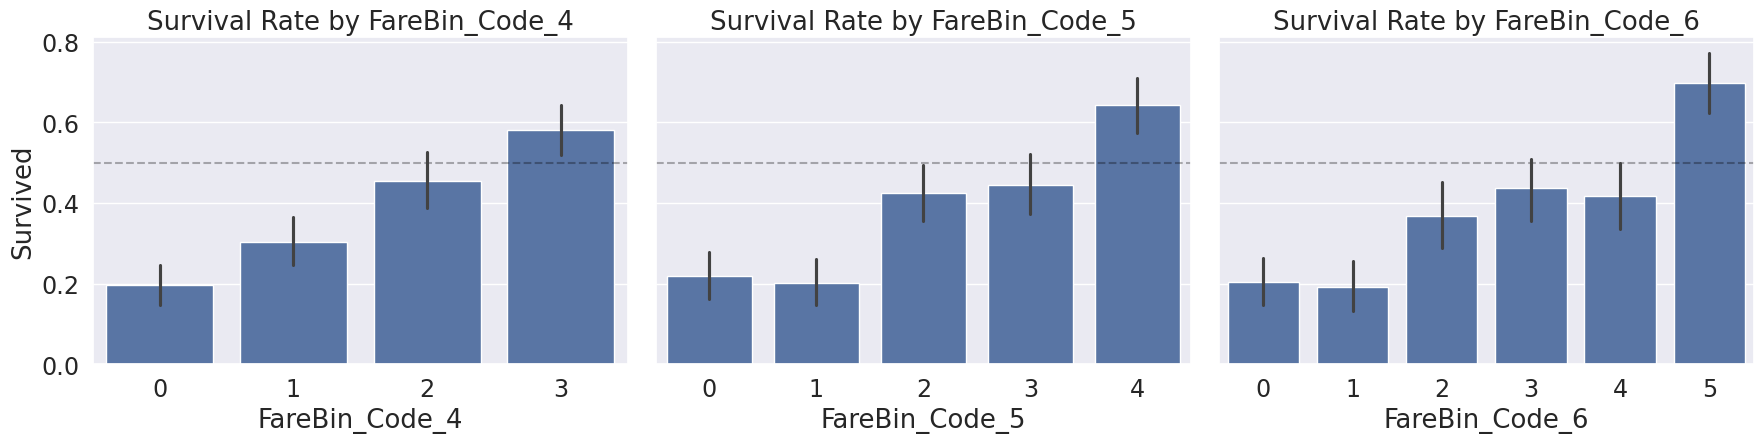

In [27]:
# loading package
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(font_scale=1.56)
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold, learning_curve, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import RFECV
# for display dataframe
from IPython.display import display
from IPython.display import display_html
from sklearn.preprocessing import LabelEncoder
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)
# ignore warning
import warnings
warnings.filterwarnings("ignore")

# #裝箱法（離散化)Making Bins
df_train_feature['FareBin_4'] = pd.qcut(df_train_feature['Fare'], 4)
df_train_feature['FareBin_5'] = pd.qcut(df_train_feature['Fare'], 5)
df_train_feature['FareBin_6'] = pd.qcut(df_train_feature['Fare'], 6)

label = LabelEncoder()
df_train_feature['FareBin_Code_4'] = label.fit_transform(df_train_feature['FareBin_4'])
df_train_feature['FareBin_Code_5'] = label.fit_transform(df_train_feature['FareBin_5'])
df_train_feature['FareBin_Code_6'] = label.fit_transform(df_train_feature['FareBin_6'])

# cross tab
df_4 = pd.crosstab(df_train_feature['FareBin_Code_4'],df_train_feature['Pclass'])
df_5 = pd.crosstab(df_train_feature['FareBin_Code_5'],df_train_feature['Pclass'])
df_6 = pd.crosstab(df_train_feature['FareBin_Code_6'],df_train_feature['Pclass'])

display_side_by_side(df_4,df_5,df_6)

# Updated plots
fig, [ax1, ax2, ax3] = plt.subplots(1, 3, sharey=True)
fig.set_figwidth(18)

# Add horizontal line to each subplot for visual reference
for axi in [ax1, ax2, ax3]:
    axi.axhline(0.5, linestyle='dashed', color='black', alpha=0.3)

# Create bar plots using sns.barplot
sns.barplot(x='FareBin_Code_4', y='Survived', data=df_train_feature, ax=ax1)
sns.barplot(x='FareBin_Code_5', y='Survived', data=df_train_feature, ax=ax2)
sns.barplot(x='FareBin_Code_6', y='Survived', data=df_train_feature, ax=ax3)

# Set titles for each subplot
ax1.set_title('Survival Rate by FareBin_Code_4')
ax2.set_title('Survival Rate by FareBin_Code_5')
ax3.set_title('Survival Rate by FareBin_Code_6')

# Adjust layout
plt.tight_layout()
plt.show()


In [28]:
# splits again beacuse we just engineered new feature
df_train = df_train_feature[:len(df_train)]
df_test = df_train_feature[len(df_train):]
# Training set and labels
X = df_train.drop(labels=['Survived','PassengerId'],axis=1)
Y = df_train['Survived']
# show columns
X.columns

Index(['Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare',
       'Cabin', 'Embarked', 'FareBin_4', 'FareBin_5', 'FareBin_6',
       'FareBin_Code_4', 'FareBin_Code_5', 'FareBin_Code_6'],
      dtype='object')

In [29]:
X['Sex'] = X['Sex'].map({'female': 0, 'male': 1})  # 性別轉碼
print(df_train['Sex'])
df_train['Sex'].describe()

0        male
1      female
2      female
3      female
4        male
        ...  
886      male
887    female
888    female
889      male
890      male
Name: Sex, Length: 891, dtype: object


,Sex
count,891
unique,2
top,male
freq,577


In [30]:
compare = ['Sex','Pclass','FareBin_Code_4','FareBin_Code_5','FareBin_Code_6']
selector = RFECV(RandomForestClassifier(n_estimators=250,min_samples_split=20),cv=10,n_jobs=-1)
selector.fit(X[compare], Y)
print(selector.support_)
print(selector.ranking_)
# 取得交叉驗證的平均分數
mean_scores = selector.cv_results_['mean_test_score']
print(mean_scores * 100)  # 轉換成百分比顯示

#證明分六份的結果效果執行成果最好


[ True  True  True  True  True]
[1 1 1 1 1]
[78.67290886 77.44444444 79.01747815 79.35580524 80.3670412 ]


In [31]:
score_b4, score_b5, score_b6 = [], [], []
seeds = 10

for i in range(seeds):
    diff_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=i)
    selector = RFECV(RandomForestClassifier(random_state=i, n_estimators=250, min_samples_split=20),
                     cv=diff_cv, n_jobs=-1)
    selector.fit(X[compare], Y)

    # 改用 selector.cv_results_['mean_test_score']
    mean_scores = selector.cv_results_['mean_test_score']

    # 添加第 3, 4, 5 個特徵組合的平均分數
    score_b4.append(mean_scores[2])
    score_b5.append(mean_scores[3])
    score_b6.append(mean_scores[4])

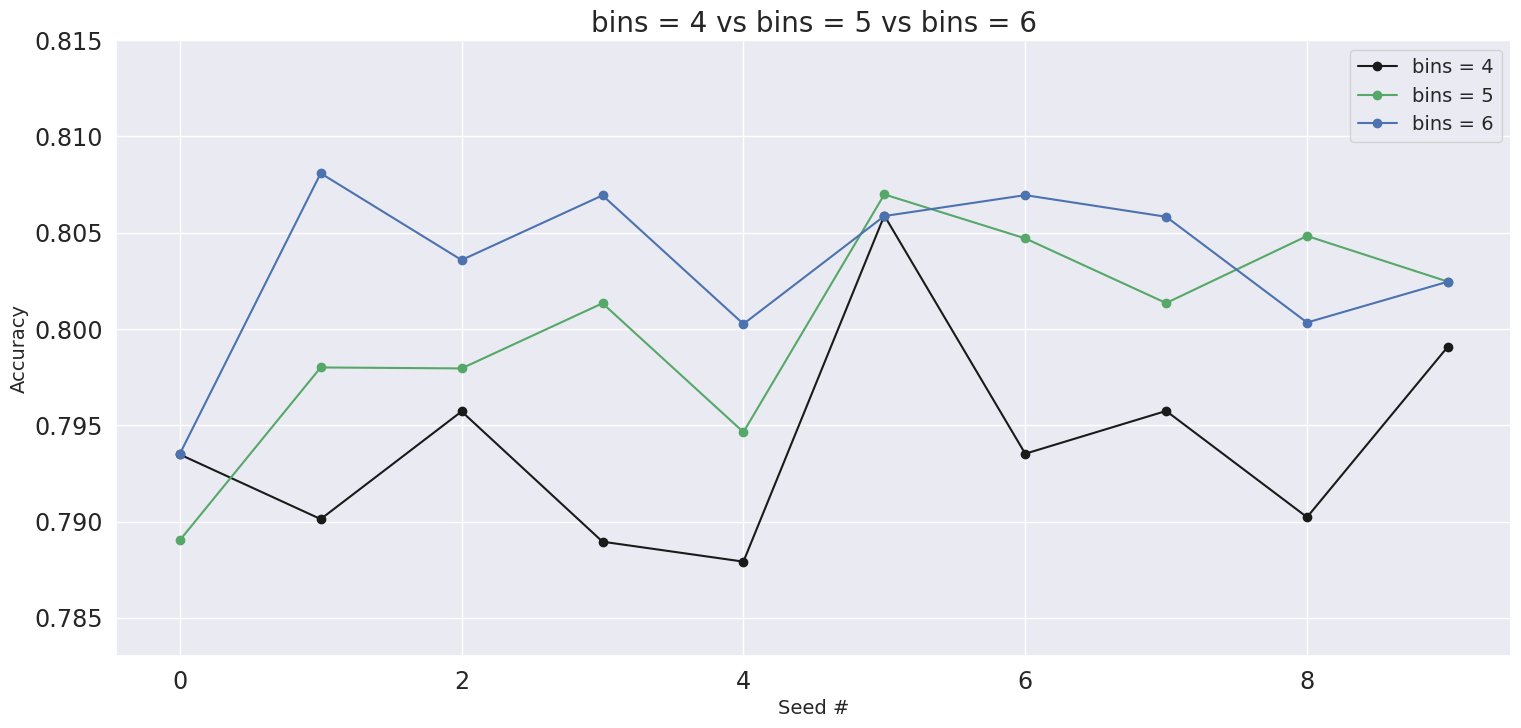

In [32]:
# to np.array
score_list = [score_b4, score_b5, score_b6]
for item in score_list:
    item = np.array(item*100)
# plot
fig = plt.figure(figsize= (18,8) )
ax = plt.gca()
ax.plot(range(seeds), score_b4,'-ok',label='bins = 4')
ax.plot(range(seeds), score_b5,'-og',label='bins = 5')
ax.plot(range(seeds), score_b6,'-ob',label='bins = 6')
ax.set_xlabel("Seed #", fontsize = '14')
ax.set_ylim(0.783,0.815)
ax.set_ylabel("Accuracy", fontsize = '14')
ax.set_title('bins = 4 vs bins = 5 vs bins = 6', fontsize='20')
plt.legend(fontsize = 14,loc='upper right')

In [35]:
b4, b5, b6 = ['Sex', 'Pclass','FareBin_Code_4'], ['Sex','Pclass','FareBin_Code_5'],\
['Sex','Pclass','FareBin_Code_6']
b4_Model = RandomForestClassifier(random_state=2,n_estimators=250,min_samples_split=20,oob_score=True)
b4_Model.fit(X[b4], Y)
b5_Model = RandomForestClassifier(random_state=2,n_estimators=250,min_samples_split=20,oob_score=True)
b5_Model.fit(X[b5], Y)
b6_Model = RandomForestClassifier(random_state=2,n_estimators=250,min_samples_split=20,oob_score=True)
b6_Model.fit(X[b6], Y)
print('b4 oob score :%.5f' %(b4_Model.oob_score_),'   LB_Public : 0.7902')
print('b5 oob score :%.5f '%(b5_Model.oob_score_),' LB_Public : 0.7936')
print('b6 oob score : %.5f' %(b6_Model.oob_score_), '  LB_Public : 0.8037')

#最後抓出較準確的結果為分五份的結果，並以此作為後續整體考量的feature

b4 oob score :0.79686    LB_Public : 0.7902
b5 oob score :0.81033   LB_Public : 0.7936
b6 oob score : 0.80135   LB_Public : 0.8037
